In [2]:
import numpy as np
import emcee
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import corner
import corner
import time 
from scipy.stats import norm, laplace

from scipy.stats import anderson_ksamp, ks_2samp, shapiro
from scipy.optimize import curve_fit


In [3]:
data = pd.read_csv("../../csvs/trap_ic4_1e8.csv", index_col=0)
#divide time by period of innermost to get the time in terms of orbits
data["t"] /=0.0041
data.head()

,runstring,t
0,0000000.bin,1.196862e+06
1,0000001.bin,1.396064e+05
2,0000002.bin,1.180004e+07
3,0000003.bin,6.899055e+05
4,0000004.bin,8.482093e+04


(array([ 3.,  4.,  8.,  6., 16., 16., 25., 48., 69., 85., 76., 60., 36.,
        25.,  8.,  6.,  3.,  2.,  2.,  2.]),
 array([4.28251828, 4.44113743, 4.59975659, 4.75837574, 4.9169949 ,
        5.07561405, 5.2342332 , 5.39285236, 5.55147151, 5.71009066,
        5.86870982, 6.02732897, 6.18594813, 6.34456728, 6.50318643,
        6.66180559, 6.82042474, 6.9790439 , 7.13766305, 7.2962822 ,
        7.45490136]),
 <a list of 20 Patch objects>)

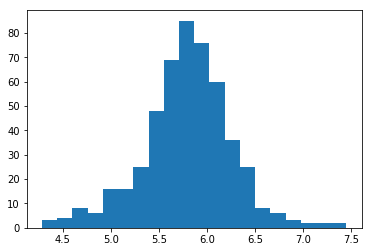

In [4]:
times = np.log10(data["t"])
plt.hist(times, bins = 20)

In [5]:
# Then, define the probability distribution that you would like to sample.
def lnprob(p, vec):
    diff = vec-p[0]
    N = len(vec)
    #probs = 
    if p[1] <=0:
        return -np.inf#0
    try:
        probs = -0.5 * N * np.log(2. * np.pi) - N/2. * np.log(np.abs(p[1])**2) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
    except:
        probs = 0.00
    return probs
       
def log_prob_normed(mu, sigma, info):
    prob = -np.log(2*np.pi)/2. - np.log(sigma**2.)/2.-(1./(sigma**2.)/2./info.shape[0])*np.nansum((info-mu)**2.)
    #print 
    return prob

In [6]:
nwalkers = 20
ndim = 2
iterations = 1000

# Choose an initial set of positions for the walkers.
p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[times], a=5)

# Run 200 steps as a burn-in.
#print "Burning in ..."
pos, prob, state = sampler.run_mcmc(p0, 200)

# Reset the chain to remove the burn-in samples.
sampler.reset()

print "Running MCMC ...",
start = time.time()
pos, prob, state = sampler.run_mcmc(pos, iterations, rstate0=0)
end = time.time()
print "Done at ...", (end - start), "seconds." 
#af = sampler.acceptance_fraction
#print "Mean acceptance fraction:", np.mean(af)


#Determine the best mean and sigma
maxprob_indice = np.argmax(prob)
mean_fit, sigma_fit = pos[maxprob_indice]
sigma_fit = np.abs(sigma_fit)

Running MCMC ... Done at ... 9.6438369751 seconds.


In [7]:
print mean_fit, sigma_fit

5.793041447461275 0.4616077315302039


0.09090010387130876


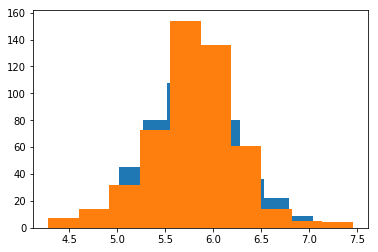

In [8]:
np.random.seed(0)
test = np.random.normal(loc=mean_fit, scale=sigma_fit, size = data.shape[0])
plt.figure()
plt.hist(test)
plt.hist(times)

try:
    statistic, p_val = ks_2samp(times, test)
except:
    statistic, p_val = 0,0
print (p_val)

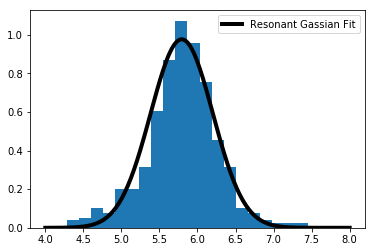

In [12]:
x = np.linspace(4, 8, 200)

#compare with the sigma parameters found from the resonant gaussian fit. 
avg_sigma = 0.409

rv = norm(loc = mean_fit, scale = avg_sigma)
plt.plot(x, rv.pdf(x), linewidth = 4, color = "black", label="Resonant Gassian Fit" )
plt.hist(times, normed=1, bins  =20)        
plt.legend()
